In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [4]:
df=pd.read_csv("./data/tourism/KPI_touristique.csv")
trands=pd.read_csv("src/Google Trend/data/trends.csv")

In [22]:
def filter_tourism_keywords(keywords):
    """Garde uniquement les mots-clés touristiques pertinents"""
    import re
    
    # Mots-clés à EXCLURE (non-touristiques)
    EXCLUDE = [
        r'\b(oil|argan|beauty|cosmetic|shampoo|body|hair)\b',
        r'\b(recipe|food|chilli|chocolate|cake|cooking)\b',
        r'\b(bbc|news|article|blog|instagram|facebook)\b',
        r'\b(price|buy|shop|store|amazon|ebay)\b',
        r'\b(job|work|salary|visa application)\b',
    ]
    
    # Mots-clés à INCLURE (touristiques)
    INCLUDE = [
        r'\b(hotel|riad|resort|accommodation|stay|booking)\b',
        r'\b(flight|airport|airline|ticket|travel)\b',
        r'\b(tour|excursion|visit|guide|itinerary|trip)\b',
        r'\b(marrakech|casablanca|fez|chefchaouen|essaouira|tangier|agadir)\b',
        r'\b(sahara|desert|atlas|medina|kasbah|souk)\b',
        r'\b(weather|temperature|climate|best time)\b',
        r'\b(things to do|places to visit|attractions)\b',
        r'\b(restaurant|cuisine|dining)\b',
        r'\b(beach|mountain|hiking|surfing|activities)\b',
    ]
    
    filtered = []
    for kw in keywords:
        kw_lower = kw.lower()
        
        # Exclure si non-touristique
        if any(re.search(pattern, kw_lower) for pattern in EXCLUDE):
            continue
        
        # Inclure si touristique
        if any(re.search(pattern, kw_lower) for pattern in INCLUDE):
            filtered.append(kw)
    
    return filtered

In [30]:
l=trands.columns.tolist()
l.remove("Date")

In [23]:
keywords_cleaned = filter_tourism_keywords(l)
len(keywords_cleaned)
trands=trands[["Date"] + keywords_cleaned]
data=pd.merge(trands, df[['Date','TES']], on="Date")

In [25]:
l=data.columns.tolist()
l.remove("Date")
data=data[l]

### Calcul des corrélations avec décalages temporels


In [26]:
dataframe = data

target_col = 'TES'  
keyword_cols = [col for col in dataframe.columns if col != target_col]

results = []


for keyword in keyword_cols:
    correlations = {}
    
    # Tester différents lags (0 à 12 mois)
    for lag in range(1, 13):
    # Décaler la série du keyword
    
        keyword_lagged = dataframe[keyword].shift(lag)

        # Supprimer les valeurs manquantes
        valid_idx = ~(keyword_lagged.isna() | dataframe[target_col].isna())

        if valid_idx.sum() > 10:  # S'assurer qu'il y a assez de données
            # Calculer la corrélation de Pearson
            corr, p_value = pearsonr(
                keyword_lagged[valid_idx], 
                dataframe[target_col][valid_idx]
            )
            correlations[lag] = {
                'correlation': corr,
                'p_value': p_value
            }
    
    # Trouver le lag optimal (corrélation maximale)
    if correlations:
        best_lag = max(correlations.keys(), 
                      key=lambda x: abs(correlations[x]['correlation']))
        best_corr = correlations[best_lag]['correlation']
        best_pvalue = correlations[best_lag]['p_value']
        
        results.append({
            'keyword': keyword,
            'best_lag': best_lag,
            'correlation': best_corr,
            'p_value': best_pvalue,
            'all_correlations': correlations
        })

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('correlation', 
                                    key=abs, 
                                    ascending=False)

print(results_df[['keyword', 'best_lag', 'correlation', 'p_value']])

C:\Users\masta\AppData\Local\Temp\ipykernel_13240\94221215.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(


                               keyword  best_lag  correlation       p_value
204                  marrakech airport         1     0.789740  1.052126e-37
227                          marrakech         1     0.786069  3.835629e-37
39                      marrakech souk         1     0.767942  1.600169e-34
487                    marrakech souks         1     0.759295  2.353308e-33
217                    morocco airport         1     0.756005  6.354014e-33
..                                 ...       ...          ...           ...
298           morocco itinerary 4 days         8     0.054818  4.857016e-01
133  moroccan restaurant san francisco        12     0.053004  5.056253e-01
112        moroccan restaurant seattle        11    -0.052512  5.082489e-01
76       moroccan restaurant st albans        12     0.051779  5.155229e-01
198    spain morocco itinerary 10 days         8     0.040764  6.042773e-01

[490 rows x 4 columns]


### Sélection des variables finales

In [ ]:
# Filtrer les keywords avec corrélation >= 70% (0.7)
threshold = 0.7
selected_keywords = results_df[
    abs(results_df['correlation']) >= threshold
].copy()

print(f"\nNombre de keywords sélectionnés avec corrélation >= 70% : {len(selected_keywords)}")
print("\nKeywords sélectionnés:")
print(selected_keywords[['keyword', 'best_lag', 'correlation']])

# Créer le dataset final avec les variables décalées
final_df = dataframe[[target_col]].copy()

for _, row in selected_keywords.iterrows():
    keyword = row['keyword']
    lag = row['best_lag']
    #final_df[f"{keyword}_lag{lag}"] = dataframe[keyword].shift(lag)
    final_df[f"{keyword}"] = dataframe[keyword].shift(lag)
# Supprimer les lignes avec valeurs manquantes
final_df = final_df.dropna()

#print(f"\nDataset final: {final_df.shape}")
#final_df[selected_keywords['keyword'].head(3)].to_csv('dataset_final_avec_lags.csv', index=False)
print()
print("="*80)
print("\nTop 3 keywords sélectionnés:")
print(selected_keywords[['keyword', 'best_lag', 'correlation']].head(3))


Nombre de keywords sélectionnés avec corrélation >= 70% : 10

Keywords sélectionnés:
                        keyword  best_lag  correlation
204           marrakech airport         1     0.789740
227                   marrakech         1     0.786069
39               marrakech souk         1     0.767942
487             marrakech souks         1     0.759295
217             morocco airport         1     0.756005
408        aeropuerto marrakech         1     0.729697
188  best time to visit vietnam         1     0.728172
230                   essaouira         1     0.722959
456     marrakech to casablanca         1     0.712056
126  jardin majorelle marrakech         1     0.700372


Top 3 keywords sélectionnés:
               keyword  best_lag  correlation
204  marrakech airport         1     0.789740
227          marrakech         1     0.786069
39      marrakech souk         1     0.767942


In [28]:
matrice = data[["TES","marrakech airport","marrakech","marrakech souk",]].corr()
print(matrice)

                        TES  marrakech airport  marrakech  marrakech souk
TES                1.000000           0.795864   0.835605        0.783228
marrakech airport  0.795864           1.000000   0.845051        0.866740
marrakech          0.835605           0.845051   1.000000        0.872445
marrakech souk     0.783228           0.866740   0.872445        1.000000


<Axes: >

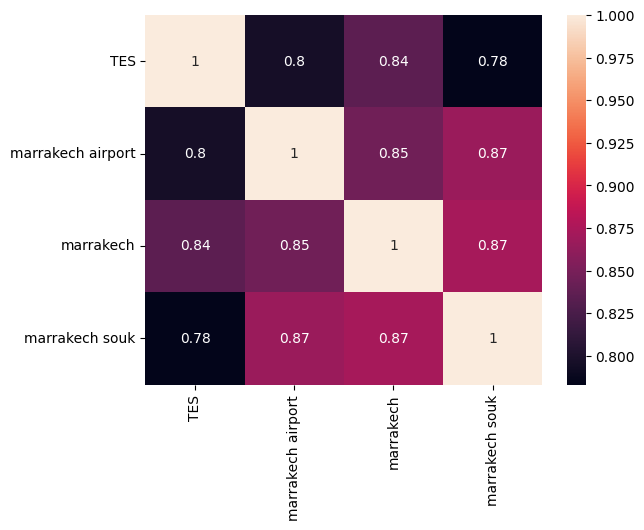

In [29]:
sns.heatmap(matrice,annot=True)